# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head(2)

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b


In [2]:
# Show df_content to get an idea of the data
df_content.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

(array([2.946e+03, 9.580e+02, 3.810e+02, 2.270e+02, 1.320e+02, 1.120e+02,
        7.600e+01, 7.200e+01, 5.400e+01, 2.300e+01, 3.100e+01, 2.000e+01,
        2.100e+01, 1.100e+01, 1.200e+01, 5.000e+00, 8.000e+00, 1.500e+01,
        6.000e+00, 4.000e+00, 5.000e+00, 3.000e+00, 6.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 4.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array

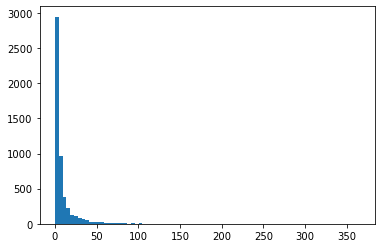

In [3]:
click_count = df['email'].value_counts()
plt.hist(click_count, bins=80, range=(0, 365))

#majority of the users only interact with one article
#a few users have >100 clicks (with multiple clicks at the same article)

In [4]:
# Fill in the median and maximum number of user_article interactios below

median_val = click_count.median()
print('50% of individuals interact with {} of articles or fewer'.format(median_val))

max_views_by_user = click_count.max()
print('The maximum number of user-article interactions by any 1 user is {}'.format(max_views_by_user))

50% of individuals interact with 3.0 of articles or fewer
The maximum number of user-article interactions by any 1 user is 364


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [5]:
unique_articles = len(set(df['article_id']))
print('The number of unique articles that have at least one interaction: {}'.format(unique_articles))

total_articles = len(set(df_content['article_id']))
print('The number of unique articles on the IBM platform: {}'.format(total_articles))

unique_users = df['email'].nunique()
print('The number of unique users: {}'.format(unique_users))
 
user_article_interactions = df.shape[0]
print('The number of user-article interactions: {}'.format(user_article_interactions))

The number of unique articles that have at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [6]:
most_viewed_article_id = str(df['article_id'].value_counts().index[0])
print('The most viewed article in the dataset (id): {}'.format(most_viewed_article_id))

max_views = df['article_id'].value_counts().max()
print('The most viewed article in the dataset was viewed {} times'.format(max_views))

The most viewed article in the dataset (id): 1429.0
The most viewed article in the dataset was viewed 937 times


In [7]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [8]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [9]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df['title'].value_counts().iloc[:n].index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df['article_id'].value_counts().iloc[:n].index.astype('str'))
 
    return top_articles # Return the top article ids

In [10]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [11]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [12]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # create the user-item matrix by groupby methods
    df_drop = df.drop_duplicates()
    user_item = df_drop.groupby(['user_id','article_id']).count().unstack().fillna(0)
    
    # remove the extra index level for ease of processing later
    user_item = user_item.droplevel(level=0, axis=1)
    
    return user_item 

user_item = create_user_item_matrix(df)

In [13]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [14]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''

    # compute similarity of each user to the provided user
    similarity = np.dot(np.array(user_item.loc[user_id]), np.transpose(np.array(user_item)))
    
    # sort by similarity
    sort_idx = similarity.argsort()[::-1]
    
    # create an array of user id for next step
    user_id_arr = np.array(user_item.index)    
    
    # create list of just the ids
    most_similar_users = list(user_id_arr[sort_idx])
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [16]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [237]:
def get_article_names(article_ids, df=df, df_content=df_content):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    df_content - (pandas dataframe) as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
                    
    Primarily output the name based on df column, 
    but use the 'doc_full_name' column in df_content if the article_id is not in the df dataframe
    
    The function can take in article_id as either str or number, but will convert it to float in the function.
    '''
    article_names = []
    
    for article_id in article_ids:
        try:
            article_id = float(article_id)
            article_names.append(df[df['article_id']==article_id]['title'].unique()[0])
        except:
            article_id = float(article_id)
            # if the article_id does not exist in df dataframe, check if it exists in df_content dataframe
            if article_id in df_content['article_id'].values:
                article_names.append(df_content[df_content['article_id']==article_id]['doc_full_name'].unique()[0])
            # if the artcile_id does not exist in either df or df_content, then print error message below
            else:
                print('article id {} is not in the dataset'.format(article_id))
                break
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids (str) seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    sort = user_item.loc[user_id,:]
    article_ids = list(sort[sort==1].index.get_level_values('article_id').astype('str'))
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    article_ids, _ = get_user_articles(user_id)
    similar_users = find_similar_users(user_id)
    
    for similar_user in similar_users:
        similar_article_ids, _ = get_user_articles(similar_user)
        # add the articles that have not been seen by the given user
        recs += list(np.setdiff1d(similar_article_ids,article_ids))
        # remove duplicates in case the same article gets added multiple times from several similar users
        recs = list(dict.fromkeys(recs))
        # only return m recommendations
        if len(recs)>=m:
            recs = recs[:m]
            break
            
    return recs  

In [238]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [239]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [20]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # compute similarity of each user to the provided user
    similarity = np.dot(np.array(user_item.loc[user_id]), np.transpose(np.array(user_item)))

    # create an array of user id for next step
    user_id_arr = np.array(user_item.index)    
    
    # create the dataframe and add the neighbor_id and similarity columns
    neighbors_df = pd.DataFrame({'neighbor_id':user_id_arr, 'similarity':similarity})
    # counts the activity of the user (for ranking purposes later)
    click_count = df['user_id'].value_counts()
    # add the num_interactions to the dataframe using click_count
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: click_count.loc[x]) 
    # sort the dataframe by user similarity first, then by user activity
    neighbors_df = neighbors_df.sort_values(['similarity','num_interactions'], ascending=[False,False])
    # remove the user itself from the neighbor dataframe
    neighbors_df = neighbors_df[neighbors_df['neighbor_id']!=user_id]
    
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    rec_names = []
    
    article_ids, _ = get_user_articles(user_id)
    article_ids = list(map(float, article_ids))
    neighbors = get_top_sorted_users(user_id)['neighbor_id']

    for neighbor in list(neighbors):
        # get the list of articles that each of the neighbor user has read/seen
        nbr_article_ids, _ = get_user_articles(neighbor)
        # convert article_id from str to float for easy manipulation
        nbr_article_ids = list(map(float, nbr_article_ids))
        # sort the articles by article popularity -- for each article, first count total clicks, sort, then get index
        nbr_article_ids_sorted = list(user_item.loc[:,nbr_article_ids].sum().sort_values(ascending=False).index)
        
        # add the articles that the user hasn't seen/read into recommendation list
        recs += list(np.setdiff1d(nbr_article_ids_sorted,article_ids))
        # remove duplicates as one article may get recommended multiple times from multiple neighbor users
        recs = list(dict.fromkeys(recs))
        
        if len(recs)>=m:
            recs = recs[:m]
            break
    
    rec_names= get_article_names(recs) 
        
    return recs, rec_names

In [21]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[12.0, 109.0, 125.0, 142.0, 164.0, 205.0, 302.0, 336.0, 362.0, 465.0]

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'tensorflow quick tips', 'statistics for hackers', 'neural networks for beginners: popular types and applications', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'accelerate your workflow with dsx', 'challenges in deep learning', 'dsx: hybrid mode', 'introduction to neural networks, advantages and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [22]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1)['neighbor_id'].iloc[0]
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].iloc[9]

In [23]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

We can make recommendations using ranked based method -- recommending the most popular (most clicked) articles.

A new user will not have any click history, so it will not be similar to any other users.

A better way would be knowledge based methods -- ask the new user to provide keywords on article titles. Proabbly an even better way is to ask for prefered article topis, which will require using NLP tools to extract topics out of the document.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [24]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [25]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

# Content based: defind article similarity 

- If a user clicks on one article, recommend other similar articles to them;

- article similarity is defined using document-term matrix based on article doc_description

In [240]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

def make_content_recs(_id, id_type='user', n_rec=10, df_content=df_content):
    '''
    INPUT:
    _id -- the id of a user that needs recommendation, or the id of a article to find similar articles
    id_type -- 'user' or 'article', type of the _id input, default as user
    n_rec -- number of recommendations to output, default at 10
    df_content -- the original dataframe with article id, title and description
    
    OUTPUT:
    recs_id -- a list of recommended articles by id
    recs_name -- a list of recommended articles by name
    '''
     
    # fill any missing description field with white space
    df_content['doc_description'].fillna(' ', inplace=True)
    # combine the article descripion and title as our document for tokenization
    df_content['main_text']=df_content.apply(lambda x:' '.join([x['doc_description'], x['doc_full_name']]), axis=1)
    corpus = list(df_content['main_text'])
    
    # use Tfidf vectorizer to transform the corpus, the tokens are features of each article to calculate similarity
    vec = TfidfVectorizer(lowercase=True, 
                          stop_words={'english'},
                          ngram_range=(1,3),
                          max_df=0.7,
                          min_df=3)
    X = vec.fit_transform(corpus)
    # convert sparse matrix to array for dot product calculation later
    X_arr = csr_matrix.toarray(X)   
    
    # create an array of article_id for locating any article in the similarity matrix
    art_ids = df_content['article_id'].values
    
    if id_type =='user':
        # get a list of article ids -- those seen by the user already. use it to find similar articles.
        seen_art_ids, _ = get_user_articles(_id)
    else:
        seen_art_ids = [_id]
        
    recs_id = []
    recs_name = []
    sim_rank = pd.DataFrame(columns=['article_id','similarity'])
    
    
    # here we will loop through at most the first 100 seen articles to find similar articles and sort by similarity 
    # if timestamp information is given for clicks, this loop can be optimized (e.g. only look at articles seen recently)
    iter_ =0
    for seen_id in seen_art_ids:  
        # for the sake of speed, stop the loop after having looked at 100 seen articles
        iter_ +=1
        if iter_ >=100:
            break
            
        # convert id datatype to float
        seen_id = float(seen_id)
        # find the index of the article of interest
        try:
            art_idx = np.where(art_ids==seen_id)[0][0]
        except:
           #print('article {} is not in our content dataset, so it is not used to find similar articles'.format(id_))
            continue
        # calculate the similarity of the article with all articles
        similarity = np.dot(X_arr[art_idx,:], np.transpose(X_arr))   
        # sort the similarity array, keep the first n_rec similar articles
        sort_idx = similarity.argsort()[::-1][:n_rec+1]
        sort_ids = art_ids[sort_idx]
        sort_sim = similarity[sort_idx]
        for sort_id, sim in zip(sort_ids,sort_sim):
            sim_rank = sim_rank.append({'article_id':sort_id, 'similarity':sim},ignore_index=True)
        sim_rank = sim_rank[sim_rank['article_id']!=seen_id]
    
    # if an article appear multiple times (similar to multiple seen articles), define similarity as the maximum similarity
    sim_rank = sim_rank.groupby('article_id')['similarity'].max().sort_values(ascending=False).iloc[:n_rec]
    recs_id = list(sim_rank.index)
    recs_name = get_article_names(recs_id)
    
    return recs_id, recs_name 

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

This recommender is developed based on similarity between articles.

The article description and title are combined as a document for each article. All documents from df_content dataframe together is our corpus. A Tfidf vectorizer is used to extract tokens from the corpus and calculate the document-term matrix. 

Then the document-term matrix is used to calculte article similarity by calculating dot product of the matrix and its transpose. For each given article, its similarity to all other articles is calculated and sorted. The top (n_rec) similar articles are found.

Based on this principle, this recommender can either:

(a) take an input of article, and find similar articles;

(b) take an input of user, first find all the seen articles by them, then find similar articles for each seen articles. Then we will rank all similar articles from all seen articles by similarity, and output the top (n_rec) ones.



`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user
  #This will not work for new user as it won't have any seen article (so no similar article)

# make a recommendations for a user who only has interacted with article id '1427.0'
  #article 1427 is not in the df_content dataset, so no article information is available for this one.
  #however, the recommender would work for someone who has only interacted with any article in the df_content dataset

In [271]:
# DEMO-1: Find similar articles as article 2
article_2 = df[df['article_id']==2]['title'].drop_duplicates().values[0]
id_2, name_2 = make_content_recs(2, id_type='article')

print('The title of the given article is:')
print(' -{}'.format(article_2))
    
print('\nThe similar articles we found include the following:')
for item in name_2:
    print(' -{}'.format(item))
    
# There are many very similar articles as article 2 and they're found by the recommender

The title of the given article is:
 -this week in data science (april 18, 2017)

The similar articles we found include the following:
 -this week in data science (april 25, 2017)
 -this week in data science (april 4, 2017)
 -this week in data science (april 11, 2017)
 -this week in data science (march 7, 2017)
 -this week in data science (march 28, 2017)
 -this week in data science (july 26, 2016)
 -this week in data science (may 2, 2017)
 -this week in data science (january 31, 2017)
 -this week in data science (january 24, 2017)
 -this week in data science (february 7, 2017)


In [272]:
# DEMO-2: Recommend articles for user 1008
seen_1008 = df[df['user_id']==1008].drop_duplicates()['title'].values
id_1008, name_1008 = make_content_recs(1008, id_type='user')

print('\nThe seen articles by this user include the following:')
for item in seen_1008:
    print(' -{}'.format(item))
    
print('\nThe recommended articles include the following:')
for item in name_1008:
    print(' -{}'.format(item))

# The recommender chooses to recommend many other articles about "visualization", which is a keyword.


The seen articles by this user include the following:
 -use r dataframes & ibm watson natural language understanding
 -ibm watson facebook posts for 2015
 -data visualization playbook: telling the data story

The recommended articles include the following:
 -data visualization playbook: revisiting the basics
 -data visualization playbook: the right level of detail
 -data visualization with r: scrum metrics
 -creating the data science experience
 -foundational methodology for data science
 -data visualization: the importance of excluding unnecessary details
 -Data visualization: Function drives design
 -let data dictate the visualization
 -Find the User in Data Science 
 -7292    a dramatic tour through python’s data visualiz...
Name: title, dtype: object


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [490]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [491]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

**Provide your response here.**

We can use regular SVD because the matrix will not have any missing value -- a use either has or has not interacted with a given article, so the user-term matrix will have either 1 or 0.

However, I think this may not be the best assumption because '0' may mean the user does not want to read this article, or it could mean the user does not know this article exists (even though they want to read it).

In [493]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

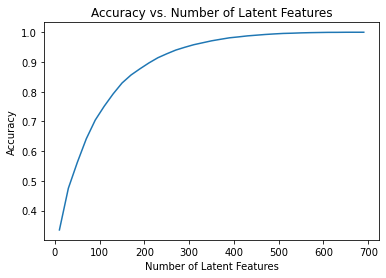

In [494]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [274]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    df_train = df_train.drop_duplicates()
    user_item_train = df_train.groupby(['user_id','article_id'])['title'].count().unstack().fillna(0)
    
    df_test = df_test.drop_duplicates()
    user_item_test = df_test.groupby(['user_id','article_id'])['title'].count().unstack().fillna(0)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [276]:
answer1 = len(set(user_item_test.index).intersection(set(user_item_train.index)))
print(answer1)

answer2 = len(user_item_test.index) - answer1
print(answer2)

answer3 = len(set(user_item_train.columns).intersection(set(user_item_test.columns)))
print(answer3)

answer4 = len(user_item_test.columns) - answer3
print(answer4)

20
662
574
0


In [278]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d
}

#t.sol_4_test(sol_4_dict)
#problem with the solution code??

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

# Notes:

I don't agree with the logic of spliting the dataset into train and test set and make "prediction" in this case.

Below I complete the exercise as suggested, but also show the results that this approach does not work

In [280]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [299]:
# use a k that is close to maximum, basically keeping all latent factor 
k=700

# get the S, U, VT based on train set data
s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

# a list of user_id that exists in both train and test set
users_ids = list(set(user_item_test.index).intersection(set(user_item_train.index)))
# a list of article_id that exists in both train and set set 
article_ids = user_item_test.columns

# an array of user_id and article_id in the train set, for locating users and articles
users_index_train = user_item_train.index.values
article_index_train = user_item_train.columns.values

error = pd.DataFrame(columns=['user_id','article_id','train_pred','test_actual','error'])

for user in users_ids:
    # find the index of the users in the train and test user-item matrix respectively
    user_idx_train = np.where(users_index_train == user)[0][0] 
    user_idx_test = np.where(test_idx == user)[0][0]
    for article in article_ids:
        # find the index of the articles in the train and set user-item matrix respectively
        article_idx_train = np.where(article_index_train == article)[0][0] 
        article_idx_test = np.where(test_arts == article)[0][0]
        
        # calculate the estimated interaction from trained model 
        user_item_est = np.around(np.dot(np.dot(u_new[user_idx_train,:], s_new),
                                         vt_new[:,article_idx_train]))
        
        # extract the "actual" interaction in test set data
        user_item_act = np.array(user_item_test)[user_idx_test,article_idx_test]
        
        # calculate the absolute value of the difference -- 1 indicates an error (failure to predict correctly)
        diff = np.abs(np.subtract(user_item_act, user_item_est))
        
        # store all relevant information into a dataframe for easy visualization and analysis
        error = error.append({'user_id':user, 'article_id':article,'train_pred':user_item_est,
                              'test_actual':user_item_act,'error':diff}, ignore_index=True)

In [303]:
from sklearn.metrics import classification_report

y_pred = error['train_pred']
y_test = error['test_actual']
print(classification_report(y_test,y_pred))

# The f1 score for predicting "click" is very low (0.12)
# This pretty much indicates the logic behind this approach does not stand.

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     11262
         1.0       0.11      0.12      0.12       218

    accuracy                           0.96     11480
   macro avg       0.55      0.55      0.55     11480
weighted avg       0.97      0.96      0.97     11480



In [302]:
# take user 2917 as an example:
# there is no correct prediction based on this approach of using train set USV to predict test set interaction

user2917_train = user_item_train.loc[2917]
print('A list of clicks for user 2917 in train set: \n  {}'.format(list(user2917_train[user2917_train==1].index)))

user2917_test = user_item_test.loc[2917]
print('A list of clicks for user 2917 in test set: \n  {}'.format(list(user2917_test[user2917_test==1].index)))

error[(error['user_id']==2917) & (error['train_pred'] + error['test_actual'] >=1)]

A list of clicks for user 2917 in train set: 
  [20.0, 62.0, 162.0, 224.0, 268.0, 415.0, 846.0, 961.0, 1016.0, 1174.0, 1393.0]
A list of clicks for user 2917 in test set: 
  [647.0, 965.0]


,user_id,article_id,train_pred,test_actual,error
9768,2917.0,20.0,1.0,0.0,1.0
9790,2917.0,62.0,1.0,0.0,1.0
9839,2917.0,162.0,1.0,0.0,1.0
9859,2917.0,224.0,1.0,0.0,1.0
9881,2917.0,268.0,1.0,0.0,1.0
9938,2917.0,415.0,1.0,0.0,1.0
10002,2917.0,647.0,0.0,1.0,1.0
10060,2917.0,846.0,1.0,0.0,1.0
10105,2917.0,965.0,-0.0,1.0,1.0
10123,2917.0,1016.0,1.0,0.0,1.0


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

This model does not perform well to predict the user-article interaction. I think the problem comes from the approach itself. When transforming df_train into a user-article matrix, we fill the NAN in the matrix with 0. This step assumes that the user does not want to interact with articles that they haven't seen. However, some of those "0" will turn out ot be "1" in the test set becaues those interactions are actually in the last 5993 rows of the original dataframe. 

A better way to do this may be using FunkSVD, along with extra information about timestamp:

Instead of filling all the NAN with 0, we keep any user-article pair value as NAN if the user or the article has not been available/active for e.g.1 week (assuming they may interact later if they're still new). In this approach, there is no train/test split. The whole df dataframe is used to generate the user-term matrix, and the NAN value can be estimated using FunkSVD.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [304]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1